## News articles : **<font color = blue>World, Business, Sports, Sci/Tech</font>**

### Data exploration

In [1]:
import pandas as pd

In [2]:
# csv has transfered id into name and focus on the Text
df = pd.read_csv('train3.csv', header=None)
df.columns = ['Category', 'Text']
df.head()

,Category,Text
0,Sports,AP - Washington Wizards point guard Steve Blak...
1,Sci/Tech,In a move designed to help it better compete i...
2,Business,US Airways #39; pilots voted to approve a new ...
3,Sci/Tech,A UK panel examining radiation risks says offi...
4,World,CARACAS -- Partisans on both sides are calling...


In [3]:
# Create new column and new category_id for each category
df['category_id'] = df['Category'].factorize()[0]

# View first 10 entries of category_idk
df['category_id'][0:10]

0    0
1    1
2    2
3    1
4    3
5    2
6    3
7    3
8    0
9    0
Name: category_id, dtype: int64

`0 Sport
 1 Sci/Tech
 2 Business
 3 World `

In [4]:
# Create a new pandas dataframe "category_id_df", use it to iterate over the categories
category_id_df = df[['Category', 'category_id']
                    ].drop_duplicates().sort_values('category_id')
category_id_df

,Category,category_id
0,Sports,0
1,Sci/Tech,1
2,Business,2
4,World,3


In [5]:
# Create a dictionary that can easily convert category names into category_ids
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category

{0: 'Sports', 1: 'Sci/Tech', 2: 'Business', 3: 'World'}

In [6]:
# Take a look at new dataframe
df.sample(5, random_state=0)

,Category,Text,category_id
12836,Business,NEW YORK (Reuters) - Consumer products compan...,2
10913,World,NEW DELHI/ISLAMABAD (Reuters) - India gave a ...,3
4214,World,"More than 1,000 people have been killed or are...",3
8198,Sci/Tech,LONDON: This one is surely good news for Simps...,1
31403,Business,"TELSTRA #39;S board, not the Federal Governmen...",2


In [7]:
# Group and count each category
df.groupby('Category').category_id.count()

Category
Business    10000
Sci/Tech    10000
Sports      10000
World       10000
Name: category_id, dtype: int64

## 1) Apply the following feature extraction techniques

### <mark>a) Term Frequency-Inverse Document Frequency (TF-IDF)<mark>
Using TfidfVectorizer to transfer news article into numerical features

Setting few TfidfVectorizer parameters: 
    1. sublinear_df: use a logarithmic form 
    2. min_df: the minimum numbers of documents a word must be present in.
       Setting it to 5 to avoid drastically increase the size of features 
       and overfitting.
    3. norm is set to l2, 
    4. encoding is set to latin-1 
    5. ngram_range: set to (1, 2) to consider both unigrams and bigrams,
    6. stop_words: set to "english" 
    7. max_features: set to 100

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

<mark> Call the fit() function in order to learn a vocabulary from tokens.<mark>

<mark> Call the transform() function to encode each document as a vector.<mark>
    
<mark> Call the .toarray() function for better understanding.<mark>

In [9]:
# create the transform
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                        ngram_range=(1, 2), stop_words='english', max_features=100)
# tokenize and encode document
features = tfidf.fit_transform(df.Text).toarray()
# There are 100 features
features.shape
# represents each article news
labels = df.category_id

<mark> use the chi-squared test to find the terms are the most correlated with each of the categories: <mark>

In [10]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category)
N = 3  # look for top 3 highly corelated to the category

# For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
    # Do chi2 analyses of all items in this category
    features_chi2 = chi2(features, labels == category_id)
    # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    indices = np.argsort(features_chi2[0])
    # Converts indices to feature names ( in increasing order of chi-squared stat values)
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # List of single word features ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # List for two-word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(
        unigrams[-N:])))  # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(
        bigrams[-N:])))  # Print 3 bigrams with highest Chi squared stat

# 'Business':
  . Most correlated unigrams:
       . stocks
       . prices
       . oil
  . Most correlated bigrams:
       . united states
       . lt gt
       . new york
# 'Sci/Tech':
  . Most correlated unigrams:
       . internet
       . software
       . microsoft
  . Most correlated bigrams:
       . united states
       . lt gt
       . new york
# 'Sports':
  . Most correlated unigrams:
       . game
       . team
       . season
  . Most correlated bigrams:
       . united states
       . new york
       . lt gt
# 'World':
  . Most correlated unigrams:
       . killed
       . minister
       . iraq
  . Most correlated bigrams:
       . united states
       . lt gt
       . new york


<mark>Visualization: use t-SNE to project high dimensional tf-idf features into a 2D plane <mark>

    Keeps similar instances close and not similar instances apart

In [11]:
# Sampling a subset of dataset because t-SNE need to run for a long time
SAMPLE_SIZE = int(len(features) * 0.05)
np.random.seed(0)
# Randomly select 5 % of samples
indices = np.random.choice(
    range(len(features)), size=SAMPLE_SIZE, replace=False)
# Array of all projected features of 5% of Randomly chosen samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(
    features[indices])

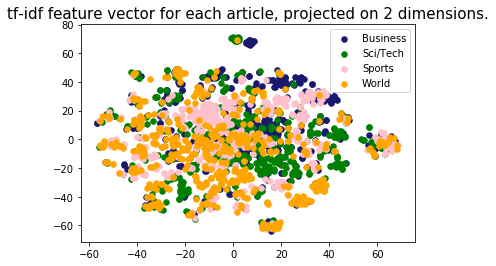

In [12]:
# Setting colors for each topics
colors = ['pink', 'green', 'midnightblue', 'orange']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30,
                c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

### <mark>b) Word2vec<mark>
<mark>Setting parameters<mark>
        
    1. size: (100) The number of dimensions of the embedding, 
       e.g. the length of the dense vector to represent each token (word).
    2. window: (30) The maximum distance between a target word and 
       words around the target word.
    3. min count: (1) The minimum count of words to consider when 
       training the model; words with an occurrence less than this count  
       will be ignored.
    4. workers: (default 3) The number of threads to use while training.
    5. sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or 
       skip gram (1).

In [9]:
from nltk.corpus import stopwords
import string
import re
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from gensim.models import word2vec
import random
from sklearn.manifold import TSNE
pd.options.display.max_colwidth = 200
%matplotlib inline

<mark>Loading and cleaning data<mark>

In [10]:
# Load data
corpus_df = pd.read_csv('train3.csv', header=None)
corpus_df.columns = ['Category', 'Document']
corpus = corpus_df['Document'].values

# Cleaning training data
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus.shape

(40000,)

<mark>Build Word2Vec model<mark>

In [11]:
# Build model
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality
window_context = 30          # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, iter=50)

<mark>Explore Word2Vec model<mark>

In [19]:
# Model Vocabulary Size: 50182 - Embedding Dim: 100
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

# Model vocabuary list
words = list(w2v_model.wv.vocab)
print(words[:10])

# access vector for one word
print(w2v_model['guard'])

# Most related words
print(w2v_model.wv.most_similar(positive=["oil"]))

# Correlation between 2 words
print(w2v_model.wv.similarity("league", "baseball"))

# calculate the maximum sequence length
max_length = max([len(s.split()) for s in norm_corpus])
print(f'Maximum length: {max_length}')

Vocabulary Size: 50182 - Embedding Dim: 100
['ap', 'washington', 'wizards', 'point', 'guard', 'steve', 'blake', 'miss', 'first', 'month']
[  3.3716004   -2.9603984   -3.640577    -3.2386382    0.4065305
   1.067771    -0.53054786   2.11635     -5.978272    -0.6338882
   5.1897883    0.57497823  -4.9498196    2.8827465    1.5240488
   3.6161666    3.6119282    4.004375    -0.2223328   -1.0752296
  -0.78175664  -1.1810039    0.04156739   2.146526    -5.0244846
   0.5011676   -3.2687488    0.3786276    4.295191     1.6838958
   4.165937    -4.1440396   -6.8276305   -0.50004095  -0.8251122
   1.9076904    0.39307225   0.5192674   -0.3864958   -2.1152892
   1.6740458  -11.040649     2.3372052    1.4754444    2.0602553
   0.7038459    0.33479595   3.789001     2.9695334    0.6384416
   1.8551805    6.3221846    1.4172565    0.12949617  -1.754605
  -0.4233755    1.3177272    3.9077969   -1.1028183   -2.9941688
   3.2620463   -2.5176756    0.96278834  -1.8086783    0.13493995
  -5.2254353   -0

D:\Anaconda\envs\tf5-nogpu\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Maximum length: 88


<mark>Visualizing word2vec word embeddings using t-SNE (print 50 words)<mark>

In [27]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    except KeyError:
        return 0


def token2word(token):
    return w2v_model.wv.index2word[token]

D:\Anaconda\envs\tf5-nogpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


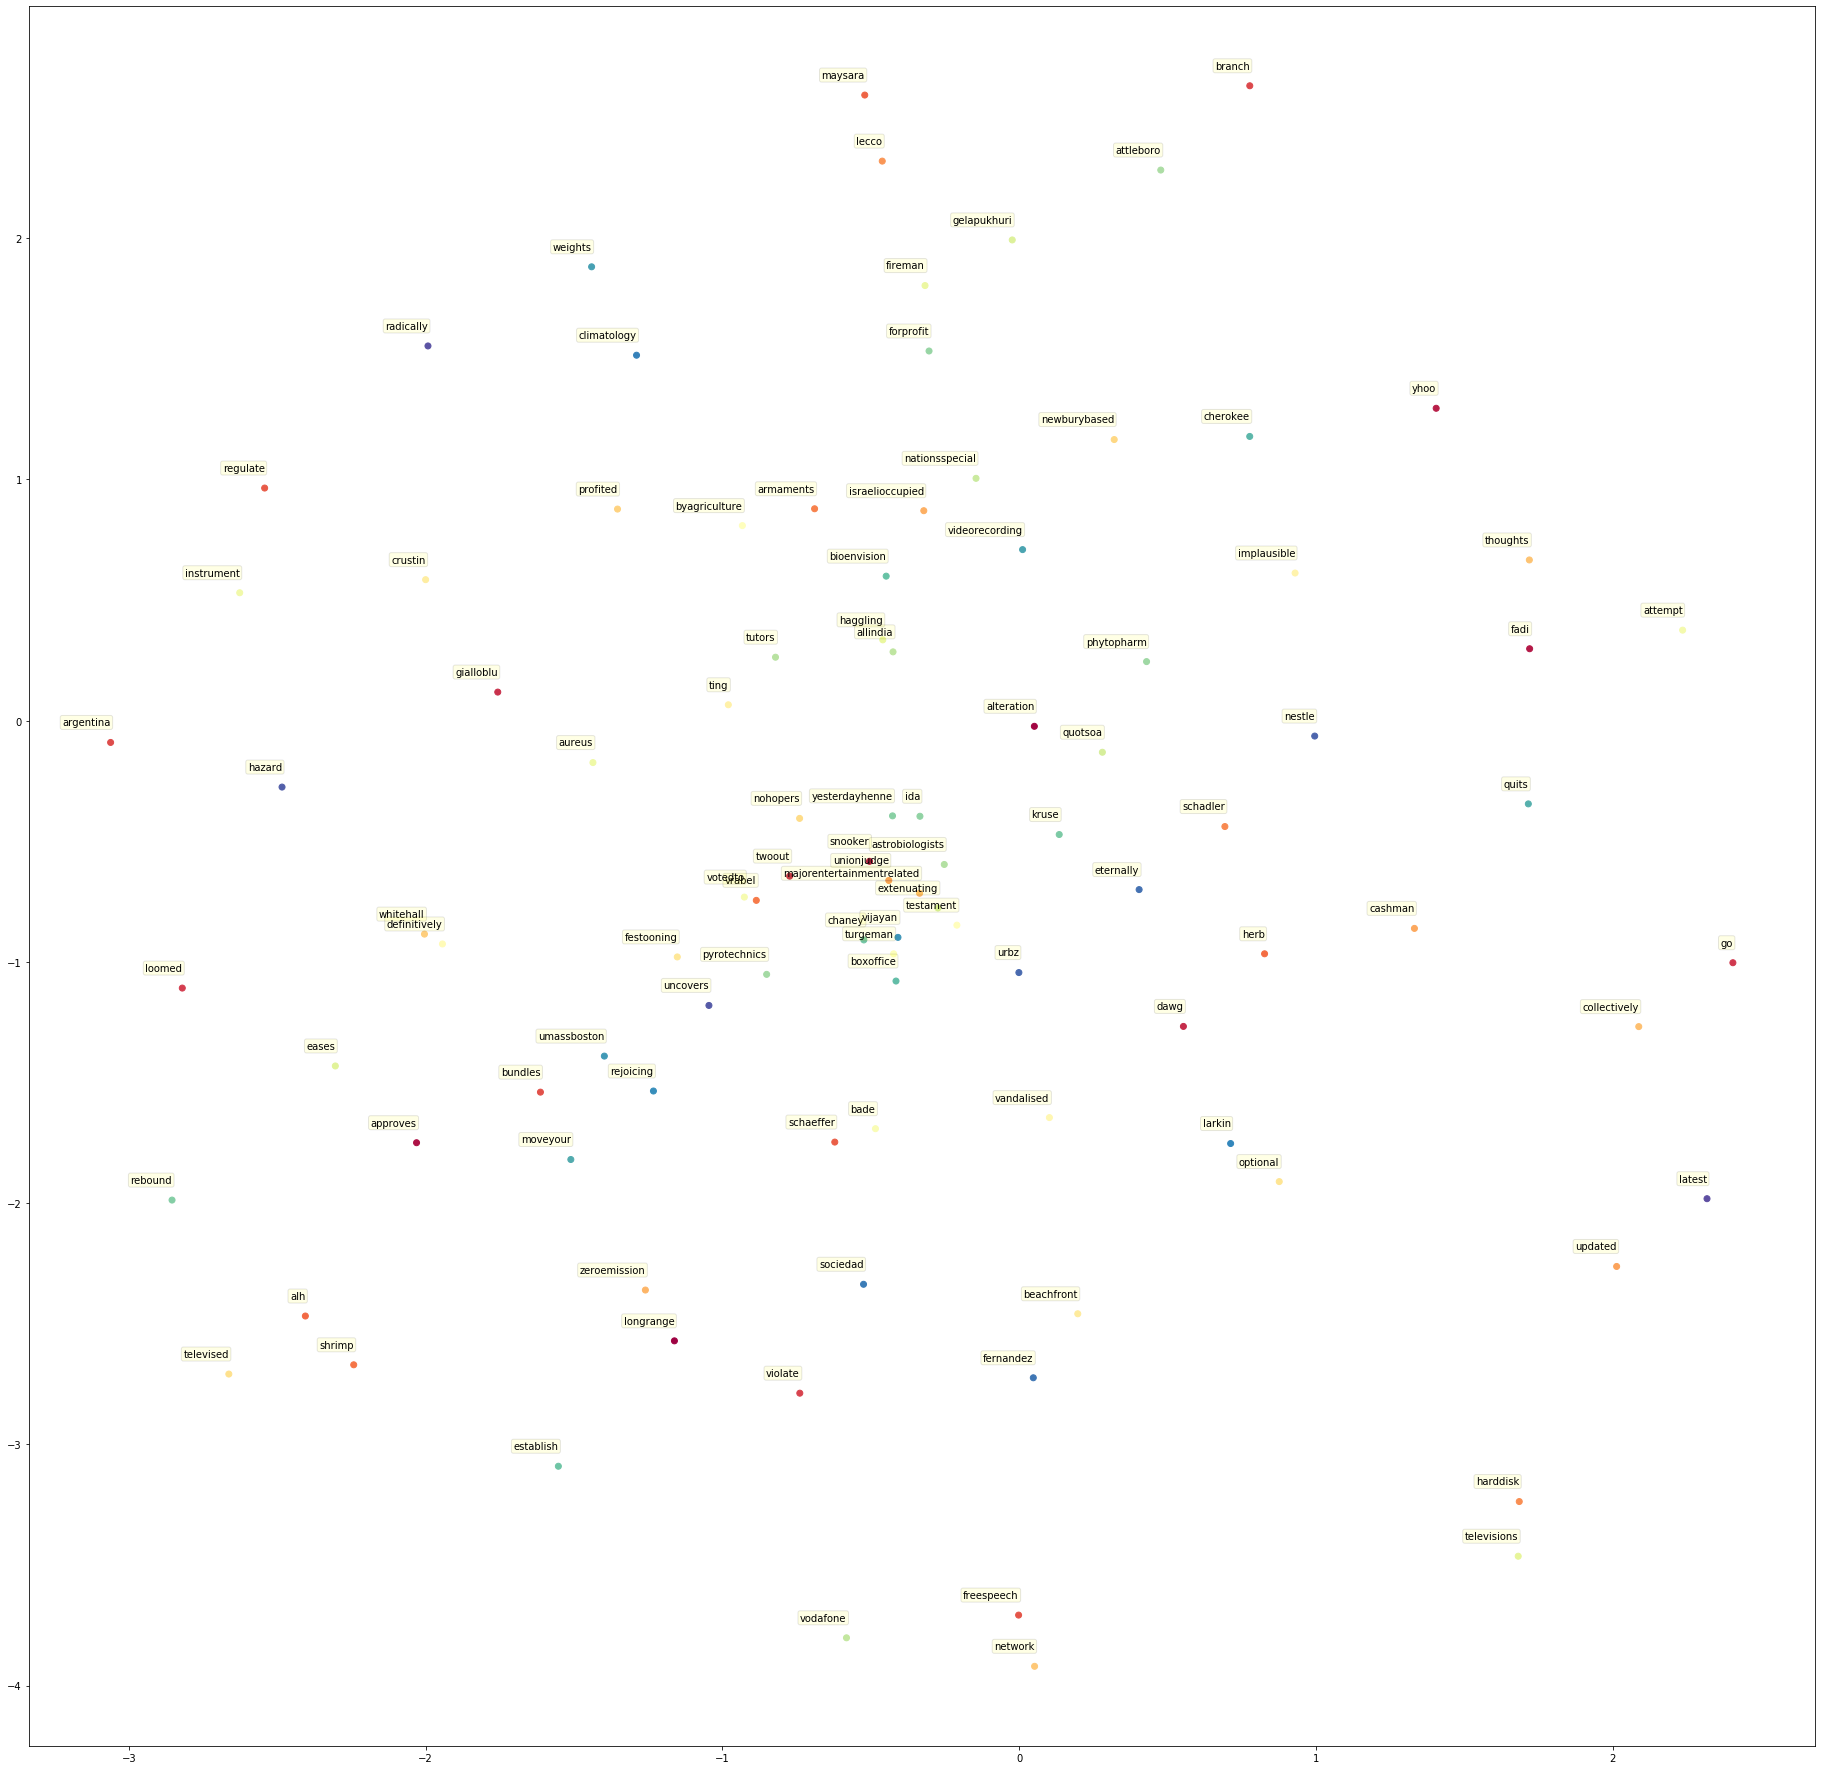

In [29]:
n_samples = 100
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([w2v_model[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(
    len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

## 2) Use features extractions from step above to train a Machine Learning algorithm

### Try 5 different classification models on TF-IFDF & Word2Vec features

<mark>Logistic Regression<mark>
    
<mark>ForestClassifier<mark>
    
<mark>MultinomialNB (Naive Bayes)<mark>   
    
<mark>KNeighborsClassifier<mark>  
    
<mark>SVM<mark> 
    
Choose the best classifier by runnung their accuracy

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<mark>Each model will be run 5 times with different test sets of 20%<mark> 


In [21]:
# Set models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3),
    SVC()
]

# Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []  # Initially all entries are empty

# For each Algorithm
for model in models:
    model_name = model.__class__.__name__
    # create 5 models with different 20% test sets, and store their accuracies
    accuracies = cross_val_score(
        model, features, labels, scoring='accuracy', cv=CV)
    # Append all 5 accuracies into the entries list
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

<mark>Plot the results<mark> 

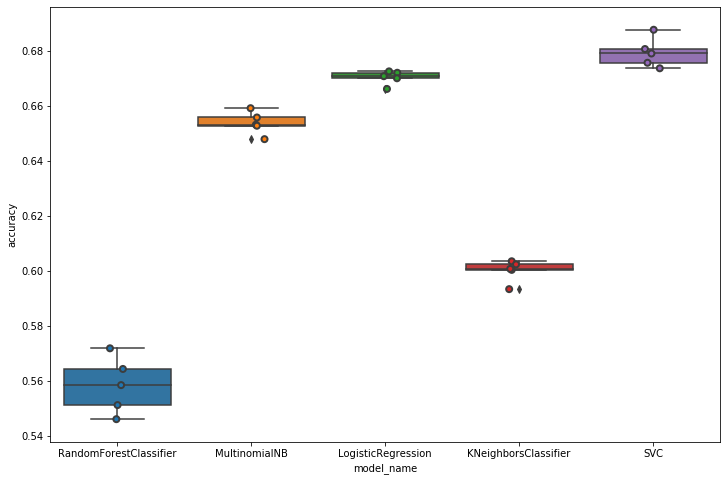

In [22]:
# Store the entries into the results dataframe and name its columns
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=(12, 8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=6, jitter=True, edgecolor="gray", linewidth=2)

<mark>Mean accuracy of each algorithm<mark> 

In [23]:
# Mean accuracy of each algorithm
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.600075
LogisticRegression        0.670275
MultinomialNB             0.653725
RandomForestClassifier    0.558425
SVC                       0.679300
Name: accuracy, dtype: float64

**<font color = red>Thus, choose SVM and Logistic Regression</font>**


### Fitting Model: SVM (TF-IDF features) (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import display
from sklearn.metrics import classification_report

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [13]:
# (Training data from train.csv, Testing data from test.csv)
# csv has transfered id into name and first focus on the Text
#import test.csv
df2 = pd.read_csv('test3.csv', header=None)
df2.columns = ['Category', 'Text']
df2.head()
df2['category_id'] = df2['Category'].factorize()[0]

# Create a new pandas dataframe "category_id_df", use it to iterate over the categories
category_id_df2 = df2[['Category', 'category_id']
                      ].drop_duplicates().sort_values('category_id')
print(category_id_df2)

# Create a dictionary that can easily convert category names into category_ids
category_to_id2 = dict(category_id_df2.values)
id_to_category2 = dict(category_id_df2[['category_id', 'Category']].values)
print(id_to_category2)

# tokenize and encode document
features2 = tfidf.fit_transform(df2.Text).toarray()
# There are 100 features
features2.shape
# represents each article news
labels2 = df2.category_id

# tokenize and encode document
features = tfidf.fit_transform(df.Text).toarray()
features2 = tfidf.fit_transform(df2.Text).toarray()

# represents each article news
labels = df.category_id
labels2 = df2.category_id

   Category  category_id
0    Sports            0
1  Sci/Tech            1
2  Business            2
3     World            3
{0: 'Sports', 1: 'Sci/Tech', 2: 'Business', 3: 'World'}


In [14]:
# Set training & testing data
X_train = features
y_train = labels
X_test = features2
y_test = labels2
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000, 100)
(40000,)
(4000, 100)
(4000,)


<mark>Train & Make predictions by SVM<mark> 

In [19]:
# Set model
model = SVC()

# Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

<mark>Print SVM confusion matrix in test data <mark> 

Text(0.5, 15.0, 'Predicted')

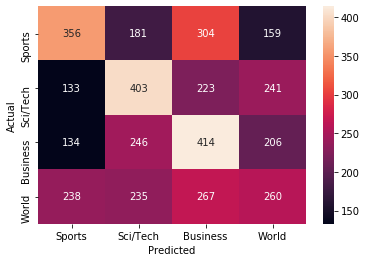

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

<mark>Print some miscategorised articles<mark>

In [21]:
indices_train = df.index
indices_test = df2.index
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print("'{}' predicted as '{}' : {} examples.".format(
                id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual)
                                        & (y_pred == predicted)]]['Text'])
            print('')

'Sci/Tech' predicted as 'Sports' : 133 examples.


113     AP - President Vladimir Putin says he will fig...
152     The US military was investigating Thursday a N...
160     It is reported that another  quot;Champion Sup...
164     Computer Associates International Inc. (CA) pl...
195     NEW YORK - Nervous investors sent stocks mostl...
                              ...                        
3851    Newest HDTV is the largest such device designe...
3879    The Chase for the Nextel Cup will begin in ear...
3891    EILAT, Israel Thousands of Israelis trudged th...
3902    In an official message broadcast on national T...
3932    Jennifer Capriati believes she has what it tak...
Name: Text, Length: 133, dtype: object


'Business' predicted as 'Sports' : 134 examples.


11      With insurance claim projections from Hurrican...
40      MONTERREY, Mexico - Governments throughout Mex...
93       Manassas took a major step this week toward e...
103     Sears, Roebuck and Co., which has successfully...
136     RMC Group was founded by Danish engineer Kjeld...
                              ...                        
3923    California will become hotter and drier by the...
3931    America Online reversed course and said it wou...
3953    Reuters - Javier Valentin smacked a three-run\...
3965    ACE Ltd. yesterday became the latest insurance...
3980    AP - Reformist opposition candidate Traian Bas...
Name: Text, Length: 134, dtype: object


'World' predicted as 'Sports' : 238 examples.


14      Reuters - Drugstore chain Rite Aid Corp. \on T...
24      Companies are accused of infecting PCs, and th...
57      The government of Prime Minister Ariel Sharon ...
68      Agrees to \$210M Justice Dept. deal and propos...
69      One of the men most wanted for war crimes comm...
                              ...                        
3906    AP - Yoshikazu Ogawa stood outside the pile of...
3933    Lycos Europe has axed the distribution of a co...
3940    CAIRO, Nov 15 (AFP) - The Arab world is abuzz ...
3956    The scientist who created Dolly the Sheep at E...
3985    Home builder Lennar Corp. (LEN.N: Quote, Profi...
Name: Text, Length: 238, dtype: object


'Sports' predicted as 'Sci/Tech' : 181 examples.


29      The Easyjet founder teams up with UK download ...
53      Rap artist ODB collapses and dies, aged 35, wh...
84      Race car driver Tommy Baldwin was killed in a ...
99      PUBS group JD Wetherspoon today said a sales s...
110     A record \$12.5 million grant to be announced ...
                              ...                        
3926    Safe boxes from a bank branch were taken away ...
3927    More than a month after sustaining burns in a ...
3937    VSNL, Indias largest telecommunications servic...
3971    BEAVER CREEK - Most individuals wouldn #39;t b...
3974    AP - Cambodia began three days of celebrations...
Name: Text, Length: 181, dtype: object


'Business' predicted as 'Sci/Tech' : 246 examples.


17       SEOUL (Reuters) - South Korean President Roh ...
20      AP - A suicide bombing at a Shiite mosque Sund...
35      Prime Minister Manmohan Singh will arrive in S...
36      A battle group of British troops began to roll...
58      Cisco Systems Inc. on Tuesday reported signifi...
                              ...                        
3966    AP - Former President Clinton may be out on th...
3987    A Connecticut computer hacker was arrested yes...
3989    New Delhi, Sep 7 (UNI) What was External Affai...
3990    France #39;s biggest carmaker, PSA Peugeot-Cit...
3993    Jailed Palestinian uprising leader Marwan Barg...
Name: Text, Length: 246, dtype: object


'World' predicted as 'Sci/Tech' : 235 examples.


5       SYDNEY : Australian airline Virgin Blue announ...
13      In his most forceful move yet to bring an end ...
31      BERLIN : Four US soldiers accused of abusing p...
41      Bloated corpses and weeping relatives have fil...
60      IBM (IBM) said Tuesday that it would sell its ...
                              ...                        
3942    Auto parts maker Tower Automotive Inc. (TWR.N:...
3948    AP - With Justin Zwick hindered by a slightly ...
3964    SYDNEY (Dow Jones)--Australian energy company ...
3970    Antivirus vendor may pay \$13 billion for the ...
3999    A Russian physicist convicted of spying for Ch...
Name: Text, Length: 235, dtype: object


'Sports' predicted as 'Business' : 304 examples.


0       AP - Washington Wizards point guard Steve Blak...
9       It was two years ago when Ernie Els explained ...
22      AP - International Business Machines Corp. sai...
33      The British Ministry of Defense confirmed on S...
52      Internet major Yahoo Inc will have a 25-member...
                              ...                        
3914     BEIT LAHIYA, Gaza Strip (Reuters) - Israeli t...
3951    Google might close the bidding in its auction-...
3957    Time Warner finally pulled the plug on CNNfn. ...
3958    Blaming the complexity of the task, Nortel Net...
3968    MANILA (Dow Jones)--President Gloria Macapagal...
Name: Text, Length: 304, dtype: object


'Sci/Tech' predicted as 'Business' : 223 examples.


25       MIAMI (Reuters) - The eastern Caribbean islan...
37      The Supreme Court has stayed the election and ...
46      LINCOLN, Neb. -- University of Nebraska-Lincol...
54      Jenson Button has remained silent about his de...
56      Reuters - India's dwindling aboriginal\populat...
                              ...                        
3963    Jordan have confirmed that Timo Glock will rep...
3982    NAGPUR: After all the cameras had stopped roll...
3983    : A misdemeanor court convicted a defrocked Ir...
3988    NEW YORK, December 3 (newratings.com) - The Bo...
3994     ROME (Reuters) - Simona Torretta and Simona P...
Name: Text, Length: 223, dtype: object


'World' predicted as 'Business' : 267 examples.


3       A UK panel examining radiation risks says offi...
10      Shares of Sirius Satellite Radio Inc. (SIRI.O:...
26      SEOUL -- North Korea suggested yesterday that ...
39      US gymnast Paul Hamm can keep the gold medal h...
50      As part of its reincarnation, America Online I...
                              ...                        
3938    Linux and identity management will be Novell #...
3947    ATHENS -- In one of the greatest 100-meter rac...
3976    Whistling Straits has received magnificent rev...
3978    Warring parties in Sudan  #39;s Darfur region ...
3991    Public and private comments from Kobe Bryant h...
Name: Text, Length: 267, dtype: object


'Sports' predicted as 'World' : 159 examples.


21      New York  Reuters News Service, 30 September 2...
38      Quarterback Jason White, last year's Heisman w...
44      LONDON, UK : Sep 26 (PNS) - An unbeaten ninth ...
92      Scientists have said for decades that nicotine...
108     A World Health Organization official has warne...
                              ...                        
3830    SAN JOSE, Calif.--San Jose has a reputation as...
3839    AP - Bears cornerback Todd McMillon just laugh...
3955    A fourth man was detained Saturday in connecti...
3960    The Anglo-Dutch oil giant Shell today sought t...
3995    World number one Roger Federer of Switzerland ...
Name: Text, Length: 159, dtype: object


'Sci/Tech' predicted as 'World' : 241 examples.


30      AP - Consumer prices calmed down in November, ...
32      AP - Former New York mayor Rudolph Giuliani, a...
34      The Connecticut Sun had an off game last Satur...
61      PHILIPPINES: The tides of mud carved a random ...
89      The scandal-hit former head of the Organisatio...
                              ...                        
3889    A website is launched with the aim of educatin...
3890    SPACE.com - Astronomers have found what they b...
3925    MacCentral - The Bluetooth Special Interest Gr...
3981    SPACE.com - This is the third article in a ser...
3998    AP - Most mail to Canada must bear the complet...
Name: Text, Length: 241, dtype: object


'Business' predicted as 'World' : 206 examples.


7       Honduras and other Central American countries ...
15      The dollar, whose weakness has been fueled by ...
43      Prime Minister Junichiro Koizumi shifted his e...
47       TOKYO (Reuters) - The yen recouped some of it...
106     AP - When Office Depot, Inc. stores ran an ele...
                              ...                        
3949    United goals-scored co-leader Alecko Eskandari...
3961    Kilkenny - World number two Ernie Els and Denm...
3969     NEW YORK (Reuters) - Treasuries eased into an...
3972    BERLIN -- A group of American civil rights att...
3984    Purses overflowing with cash, exotic locales, ...
Name: Text, Length: 206, dtype: object

<mark>Print some accuracy and other criterias<mark>

In [22]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,
                            target_names=category_id_df['Category'].values))

accuracy 0.35825
              precision    recall  f1-score   support

      Sports       0.41      0.36      0.38      1000
    Sci/Tech       0.38      0.40      0.39      1000
    Business       0.34      0.41      0.37      1000
       World       0.30      0.26      0.28      1000

    accuracy                           0.36      4000
   macro avg       0.36      0.36      0.36      4000
weighted avg       0.36      0.36      0.36      4000



### Fitting Model: Logistic regression (TF-IDF features)

<mark>Train & Make predictions by Logistic regression<mark> 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import display
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [15]:
model = LogisticRegression(random_state=0)

# Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

<mark>Print  Logistic regression confusion matrix in test data <mark> 

Text(0.5, 15.0, 'Predicted')

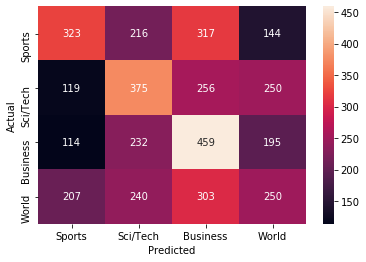

In [16]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

<mark>Print some miscategorised articles<mark>

In [17]:
indices_train = df.index
indices_test = df2.index
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print("'{}' predicted as '{}' : {} examples.".format(
                id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual)
                                        & (y_pred == predicted)]]['Text'])
            print('')

'Sci/Tech' predicted as 'Sports' : 119 examples.


113     AP - President Vladimir Putin says he will fig...
152     The US military was investigating Thursday a N...
160     It is reported that another  quot;Champion Sup...
164     Computer Associates International Inc. (CA) pl...
195     NEW YORK - Nervous investors sent stocks mostl...
                              ...                        
3774    It was a wild ride and NC State held on for as...
3846     TOKYO (Reuters) - A Japanese court granted an...
3851    Newest HDTV is the largest such device designe...
3891    EILAT, Israel Thousands of Israelis trudged th...
3932    Jennifer Capriati believes she has what it tak...
Name: Text, Length: 119, dtype: object


'Business' predicted as 'Sports' : 114 examples.


11      With insurance claim projections from Hurrican...
40      MONTERREY, Mexico - Governments throughout Mex...
80      SPAIN #39;S Prime Minister has accused the gov...
93       Manassas took a major step this week toward e...
103     Sears, Roebuck and Co., which has successfully...
                              ...                        
3923    California will become hotter and drier by the...
3931    America Online reversed course and said it wou...
3953    Reuters - Javier Valentin smacked a three-run\...
3965    ACE Ltd. yesterday became the latest insurance...
3980    AP - Reformist opposition candidate Traian Bas...
Name: Text, Length: 114, dtype: object


'World' predicted as 'Sports' : 207 examples.


57      The government of Prime Minister Ariel Sharon ...
68      Agrees to \$210M Justice Dept. deal and propos...
71      AP - Intuit Inc. posted a narrower net loss fo...
73      Questions about the effectiveness and long-ter...
114     Automakers, SUV owners, and the federal govern...
                              ...                        
3910    AP - Jhonny Peralta's two-run double keyed Cle...
3929    Sony has confirmed that its PSP handheld conso...
3933    Lycos Europe has axed the distribution of a co...
3940    CAIRO, Nov 15 (AFP) - The Arab world is abuzz ...
3985    Home builder Lennar Corp. (LEN.N: Quote, Profi...
Name: Text, Length: 207, dtype: object


'Sports' predicted as 'Sci/Tech' : 216 examples.


29      The Easyjet founder teams up with UK download ...
53      Rap artist ODB collapses and dies, aged 35, wh...
87      Hubie Brown, the oldest coach in the NBA at th...
99      PUBS group JD Wetherspoon today said a sales s...
102     American tycoon Malcolm Glazer is reportedly p...
                              ...                        
3927    More than a month after sustaining burns in a ...
3937    VSNL, Indias largest telecommunications servic...
3958    Blaming the complexity of the task, Nortel Net...
3971    BEAVER CREEK - Most individuals wouldn #39;t b...
3974    AP - Cambodia began three days of celebrations...
Name: Text, Length: 216, dtype: object


'Business' predicted as 'Sci/Tech' : 232 examples.


17       SEOUL (Reuters) - South Korean President Roh ...
20      AP - A suicide bombing at a Shiite mosque Sund...
35      Prime Minister Manmohan Singh will arrive in S...
36      A battle group of British troops began to roll...
58      Cisco Systems Inc. on Tuesday reported signifi...
                              ...                        
3945    AP - Frank Thomas is returning to the Chicago ...
3966    AP - Former President Clinton may be out on th...
3987    A Connecticut computer hacker was arrested yes...
3989    New Delhi, Sep 7 (UNI) What was External Affai...
3993    Jailed Palestinian uprising leader Marwan Barg...
Name: Text, Length: 232, dtype: object


'World' predicted as 'Sci/Tech' : 240 examples.


13      In his most forceful move yet to bring an end ...
31      BERLIN : Four US soldiers accused of abusing p...
41      Bloated corpses and weeping relatives have fil...
69      One of the men most wanted for war crimes comm...
78      London - Prince Harry will not make a public a...
                              ...                        
3941    United Airlines, the bankrupt carrier, yesterd...
3942    Auto parts maker Tower Automotive Inc. (TWR.N:...
3948    AP - With Justin Zwick hindered by a slightly ...
3964    SYDNEY (Dow Jones)--Australian energy company ...
3970    Antivirus vendor may pay \$13 billion for the ...
Name: Text, Length: 240, dtype: object


'Sports' predicted as 'Business' : 317 examples.


0       AP - Washington Wizards point guard Steve Blak...
9       It was two years ago when Ernie Els explained ...
22      AP - International Business Machines Corp. sai...
33      The British Ministry of Defense confirmed on S...
52      Internet major Yahoo Inc will have a 25-member...
                              ...                        
3919     LONDON (Reuters) - Oil prices surged to recor...
3951    Google might close the bidding in its auction-...
3957    Time Warner finally pulled the plug on CNNfn. ...
3968    MANILA (Dow Jones)--President Gloria Macapagal...
3979    Tom Brady lost his helmet and a fumble on a ha...
Name: Text, Length: 317, dtype: object


'Sci/Tech' predicted as 'Business' : 256 examples.


25       MIAMI (Reuters) - The eastern Caribbean islan...
37      The Supreme Court has stayed the election and ...
46      LINCOLN, Neb. -- University of Nebraska-Lincol...
54      Jenson Button has remained silent about his de...
56      Reuters - India's dwindling aboriginal\populat...
                              ...                        
3959    Taser International says that a study endorses...
3963    Jordan have confirmed that Timo Glock will rep...
3982    NAGPUR: After all the cameras had stopped roll...
3983    : A misdemeanor court convicted a defrocked Ir...
3988    NEW YORK, December 3 (newratings.com) - The Bo...
Name: Text, Length: 256, dtype: object


'World' predicted as 'Business' : 303 examples.


3       A UK panel examining radiation risks says offi...
5       SYDNEY : Australian airline Virgin Blue announ...
10      Shares of Sirius Satellite Radio Inc. (SIRI.O:...
14      Reuters - Drugstore chain Rite Aid Corp. \on T...
26      SEOUL -- North Korea suggested yesterday that ...
                              ...                        
3947    ATHENS -- In one of the greatest 100-meter rac...
3956    The scientist who created Dolly the Sheep at E...
3976    Whistling Straits has received magnificent rev...
3978    Warring parties in Sudan  #39;s Darfur region ...
3999    A Russian physicist convicted of spying for Ch...
Name: Text, Length: 303, dtype: object


'Sports' predicted as 'World' : 144 examples.


21      New York  Reuters News Service, 30 September 2...
38      Quarterback Jason White, last year's Heisman w...
44      LONDON, UK : Sep 26 (PNS) - An unbeaten ninth ...
67       GROZNY, Russia (Reuters) - Chechnya's new lea...
92      Scientists have said for decades that nicotine...
                              ...                        
3835    com November 1, 2004, 9:56 AM PT. This fourth ...
3839    AP - Bears cornerback Todd McMillon just laugh...
3955    A fourth man was detained Saturday in connecti...
3960    The Anglo-Dutch oil giant Shell today sought t...
3995    World number one Roger Federer of Switzerland ...
Name: Text, Length: 144, dtype: object


'Sci/Tech' predicted as 'World' : 250 examples.


1       In a move designed to help it better compete i...
30      AP - Consumer prices calmed down in November, ...
32      AP - Former New York mayor Rudolph Giuliani, a...
34      The Connecticut Sun had an off game last Satur...
61      PHILIPPINES: The tides of mud carved a random ...
                              ...                        
3889    A website is launched with the aim of educatin...
3890    SPACE.com - Astronomers have found what they b...
3925    MacCentral - The Bluetooth Special Interest Gr...
3981    SPACE.com - This is the third article in a ser...
3998    AP - Most mail to Canada must bear the complet...
Name: Text, Length: 250, dtype: object


'Business' predicted as 'World' : 195 examples.


7       Honduras and other Central American countries ...
15      The dollar, whose weakness has been fueled by ...
43      Prime Minister Junichiro Koizumi shifted his e...
47       TOKYO (Reuters) - The yen recouped some of it...
106     AP - When Office Depot, Inc. stores ran an ele...
                              ...                        
3928    A Quebec glass manufacturer will have to repla...
3961    Kilkenny - World number two Ernie Els and Denm...
3972    BERLIN -- A group of American civil rights att...
3977    Union leaders at central Florida #39;s Walt Di...
3984    Purses overflowing with cash, exotic locales, ...
Name: Text, Length: 195, dtype: object

<mark>Print some accuracy and other criterias<mark>

In [18]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,
                            target_names=category_id_df['Category'].values))

accuracy 0.35175
              precision    recall  f1-score   support

      Sports       0.42      0.32      0.37      1000
    Sci/Tech       0.35      0.38      0.36      1000
    Business       0.34      0.46      0.39      1000
       World       0.30      0.25      0.27      1000

    accuracy                           0.35      4000
   macro avg       0.35      0.35      0.35      4000
weighted avg       0.35      0.35      0.35      4000



### Fitting Model: SVM (Word2Vec features)

In [17]:
from nltk.corpus import stopwords
from gensim.models import word2vec
import string
import re
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200
%matplotlib inline

<mark>Procedure<mark>
    1. Build Word2Vec Model
    2. Document level embeddings
    3. Set X_train, y_train, x_test, y_test
    4. Fit the model

<mark>1. Build Word2Vec Model<mark>

In [18]:
# Load training data
corpus_df = pd.read_csv('train3.csv', header=None)
corpus_df.columns = ['Category', 'Document']
corpus = corpus_df['Document'].values

# Cleaning training data
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus.shape

(40000,)

In [19]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality
window_context = 30          # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

# Build model
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, iter=50)

In [20]:
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 50182 - Embedding Dim: 100


<mark> 2. Document level embeddings<mark>

It would need to get the document level embeddings from each of the words present in each news article. 
Hence, average out the word embeddings for each word in a news article. 

In [21]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)


# Get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.421981,-0.305465,-0.607938,0.592017,0.418428,1.624794,-0.549020,0.547757,0.529329,1.042906,...,-0.398469,-0.801558,-0.950280,-0.335601,-0.215839,-0.524427,1.374568,0.822815,0.134391,-0.680693
1,-1.071817,0.101328,-0.670314,0.129650,-0.800482,-0.750762,-0.320761,0.038598,-1.103811,0.062447,...,-0.634829,-0.714540,1.829801,-0.475323,0.028403,0.575363,0.158807,1.786425,-0.550789,1.104262
2,0.603930,0.315987,-0.960669,-0.026417,-0.314272,-0.764278,-0.975902,-1.198911,0.375079,1.648332,...,0.229596,-0.484894,0.539998,-0.868783,0.237100,0.915182,1.258128,1.560748,-0.829716,0.719807
3,-0.000795,0.031213,-0.873378,0.373745,-0.328484,-0.420284,-0.207870,-0.379725,-0.550374,0.248494,...,-0.042522,-0.034246,-0.870937,0.107699,0.124933,1.940840,1.037932,-0.233809,-0.648709,0.832192
4,1.019395,-0.077322,0.393598,-0.457425,0.321983,0.068873,-1.243414,-0.874803,-0.054595,-0.060445,...,0.489910,0.823524,-0.894219,-0.846039,0.295043,-0.575912,0.364308,-0.609803,-0.889047,1.098035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1.021884,0.535597,-0.434283,-0.922332,-0.144072,-0.018603,-0.068638,0.468576,1.137305,-0.115350,...,-0.131564,-0.088394,0.566270,-0.401683,0.222196,-0.360572,0.433052,-0.528214,-0.146116,0.399577
39996,0.320889,-0.076036,0.410688,-0.678471,-0.370639,1.357501,0.494719,0.942404,-0.749632,-0.391447,...,-0.449068,-0.583929,0.727180,-0.371342,0.023999,-0.207944,0.110025,-1.044238,-0.341574,-0.755663
39997,-0.009609,-0.228346,-0.011797,-1.680407,0.521500,2.394861,-0.720961,0.516011,-1.031077,-1.433284,...,0.184782,-0.316076,-1.469289,0.648637,-0.345201,-0.284542,1.006194,-1.250497,-0.398280,-0.959408
39998,-0.490485,-1.540457,0.158492,1.553908,-0.242752,-0.862852,0.550175,-0.691786,-0.747160,0.896515,...,-0.109498,-1.201005,0.184868,0.630817,-0.192306,0.740080,0.178136,0.898553,0.439615,1.512720


<mark> 3. Set X_train, y_train, x_test, y_test<mark>

In [22]:
# Load test data
corpus_df2 = pd.read_csv('test3.csv', header=None)
corpus_df2.columns = ['Category', 'Document']
corpus2 = corpus_df2['Document'].values

# Clean the testing data
norm_corpus2 = normalize_corpus(corpus2)
norm_corpus2.shape

# fit testing data into w2v model
tokenized_corpus2 = [wpt.tokenize(document) for document in norm_corpus2]

# get document level embeddings
w2v_feature_array2 = averaged_word_vectorizer(corpus=tokenized_corpus2, model=w2v_model,
                                              num_features=feature_size)
pd.DataFrame(w2v_feature_array2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.538809,-0.172287,-0.026065,-0.699985,0.603379,0.404347,0.572482,1.601316,-0.863281,-0.340765,...,-0.574100,-0.635632,-0.384180,-0.727447,0.598545,1.561471,2.468050,-0.164535,0.376849,-0.036627
1,-0.081551,0.762256,0.235652,-0.229006,-0.999317,-0.056325,0.722005,0.197283,-0.419391,0.140813,...,-0.745721,-0.236720,-0.799104,-0.278496,0.433060,0.371629,-0.068019,0.449972,-0.989895,1.438243
2,0.063950,-1.824743,-0.024658,0.823678,0.045107,-0.429113,-0.623649,-2.251980,-0.164519,2.108791,...,1.277901,-0.721891,0.665240,0.554885,-0.075829,0.230573,0.443825,1.074036,-0.339206,1.862091
3,1.999191,-0.346016,1.597196,-1.091954,1.024062,0.360829,0.555348,-0.893718,1.245290,0.606120,...,2.391694,-0.554426,-1.401193,-0.733792,0.775731,-0.155339,0.192666,-1.439020,-0.173949,-0.975405
4,0.675748,0.952563,-0.266479,0.598096,-0.081425,-0.211602,-0.105525,1.280068,0.151863,-0.031884,...,0.057903,0.748151,-0.225375,-0.502281,-0.223915,0.494791,0.495991,1.895558,-0.351877,1.970355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.966316,0.090040,-0.458965,-1.593921,0.670998,2.003940,-0.071858,-0.449871,-0.991260,-1.073583,...,-0.566980,-1.387671,0.361506,-0.283132,1.270528,-0.146984,-0.068361,0.084956,-0.057732,0.299479
3996,-0.171166,-0.032206,-0.695540,-0.868012,-0.303634,-1.608846,-1.249697,0.702734,0.094030,0.507577,...,0.959258,0.997629,0.954753,-0.368137,0.068276,-0.441767,-0.022865,-0.206460,-0.594525,0.653106
3997,0.935405,-0.613401,0.545776,-0.298327,0.253994,0.153930,0.104382,-0.964312,0.444843,0.994956,...,1.954735,-1.227290,0.456946,-0.081062,0.369229,0.708935,0.302591,0.593527,0.402936,-1.431231
3998,0.436403,-0.081537,-1.155153,0.569472,-0.821220,-0.019096,-1.731241,0.460767,-0.336501,0.400682,...,-0.267696,-0.790731,0.985031,0.681846,-0.360418,0.184452,0.101749,0.224249,-0.650540,1.006927


In [23]:
# Set X_train, y_train, x_test, y_test
df = pd.read_csv('train3.csv', header=None)
df.columns = ['Category', 'Text']
df.head()
# create new column and new category_id for Category name
df['category_id'] = df['Category'].factorize()[0]

# Create a new pandas dataframe "category_id_df", use it to iterate over the categories
category_id_df = df[['Category', 'category_id']
                    ].drop_duplicates().sort_values('category_id')
category_id_df
# Create a dictionary that can easily convert category names into category_ids
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category

df2 = pd.read_csv('test3.csv', header=None)
df2.columns = ['Category', 'Text']
df2.head()
df2['category_id'] = df2['Category'].factorize()[0]

features = pd.DataFrame(w2v_feature_array).values
features2 = pd.DataFrame(w2v_feature_array2).values
labels = df.category_id
labels2 = df2.category_id

X_train = features
y_train = labels
X_test = features2
y_test = labels2
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000, 100)
(40000,)
(4000, 100)
(4000,)


<mark> 4.Fit SVM model <mark>

In [24]:
# Set SVM model
model = SVC()

In [25]:
% % time
model.fit(X_train, y_train)

Wall time: 1min 45s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
# Save the model
from sklearn.externals import joblib
joblib.dump(model, 'svmmodel.pkl')

['svmmodel.pkl']

In [30]:
print("Training SVM using Word2Vec cost : 1 minutes 45 seconds")

Training SVM using Word2Vec cost : 1 minutes 45 seconds


In [27]:
# Make Predictions
y_pred = model.predict(X_test)

Text(0.5, 15.0, 'Predicted')

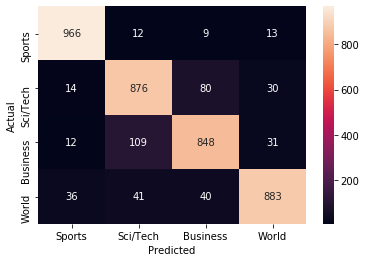

In [28]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [29]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,
                            target_names=category_id_df['Category'].values))

accuracy 0.89325
              precision    recall  f1-score   support

      Sports       0.94      0.97      0.95      1000
    Sci/Tech       0.84      0.88      0.86      1000
    Business       0.87      0.85      0.86      1000
       World       0.92      0.88      0.90      1000

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



### Fitting Model: Logistic regression (Word2Vec features)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [74]:
model = LogisticRegression(random_state=0)

# Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

In [84]:
% % time

model.fit(X_train, y_train)

Wall time: 3.06 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
print("Training Logistic regression using Word2Vec cost :3.06 seconds")

Training Logistic regression using Word2Vec cost :3.06 seconds


Text(0.5, 15.0, 'Predicted')

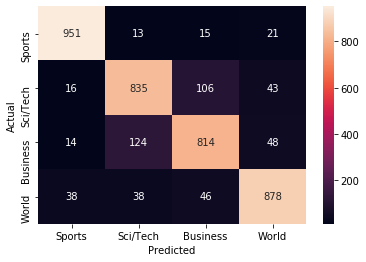

In [75]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [76]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,
                            target_names=category_id_df['Category'].values))

accuracy 0.8695
              precision    recall  f1-score   support

      Sports       0.93      0.95      0.94      1000
    Sci/Tech       0.83      0.83      0.83      1000
    Business       0.83      0.81      0.82      1000
       World       0.89      0.88      0.88      1000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



## 3) Train Deep Learning model LSTM with word2vec features extracted in step1

<mark>Loading and cleaning training data<mark>

In [8]:
from nltk.corpus import stopwords
from gensim.models import word2vec
import string
import re
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.models import load_model
pd.options.display.max_colwidth = 200
%matplotlib inline

In [7]:
# Load training data
corpus_df = pd.read_csv('train3.csv', header=None)
corpus_df.columns = ['Category', 'Document']
corpus = corpus_df['Document'].values

# Cleaning training data
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus.shape

(40000,)

<mark>Building Word2Vec Model<mark>

In [9]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality
window_context = 30          # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

# Build model
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, iter=50)

In [10]:
# Retrieve the weights from the model.
# This is used for initializing the weightsin Keras Embedding layer
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 50182 - Embedding Dim: 100


In [11]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    except KeyError:
        return 0


def token2word(token):
    return w2v_model.wv.index2word[token]

<mark>Prepare training data for LSTM<mark>

In [12]:
# Count the categories in the dataset
categories, ccount = np.unique(corpus_df.Category, return_counts=True)
n_categories = len(categories)

# Create an iterator that formats data from the dataset proper for LSTM training

# Calculate the maximum sequence length
max_length = max([len(s.split()) for s in norm_corpus])

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = max_length


class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(
            dataset.Category, return_counts=True)

        self.seq_length = seq_length

    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 1], self.dataset.iloc[:, 0]):

            # Make all characters lower-case
            news = news.lower()

            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[
                             :self.seq_length] if w != ''])

            yield (words, cat)


sequences = SequenceIterator(corpus_df, MAX_SEQUENCE_LENGTH)

# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(
    sequences.categories, range(len(sequences.categories)))}

set_x = []
set_y = []
for w, c in sequences:
    set_x.append(w)
    set_y.append(cat_dict[c])

# Padding sequences with 0.
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH,
                      padding='pre', value=0)
set_y = np.array(set_y)

print(set_x.shape)
print(set_y.shape)

(40000, 88)
(40000,)


<mark>Prepare testing data for LSTM<mark>

In [13]:
corpus_df2 = pd.read_csv('test3.csv', header=None)
corpus_df2.columns = ['Category', 'Document']

In [14]:
# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 88


class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(
            dataset.Category, return_counts=True)

        self.seq_length = seq_length

    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 1], self.dataset.iloc[:, 0]):

            # Make all characters lower-case
            news = news.lower()

            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[
                             :self.seq_length] if w != ''])

            yield (words, cat)


sequences = SequenceIterator(corpus_df2, MAX_SEQUENCE_LENGTH)

# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(
    sequences.categories, range(len(sequences.categories)))}

set_x2 = []
set_y2 = []
for w, c in sequences:
    set_x2.append(w)
    set_y2.append(cat_dict[c])

# Padding sequences with 0.
set_x2 = pad_sequences(
    set_x2, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y2 = np.array(set_y2)

print(set_x2.shape)
print(set_y2.shape)

(4000, 88)
(4000,)


<mark>Set training & testing data for LSTM<mark>

In [15]:
train_x = set_x
train_y = set_y
test_x = set_x2
test_y = set_y2

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Test Shapes - X: {} - Y: {}".format(test_x.shape, test_y.shape))

Train Shapes - X: (40000, 88) - Y: (40000,)
Test Shapes - X: (4000, 88) - Y: (4000,)


In [16]:
test_y

array([2, 1, 0, ..., 3, 1, 3])

<mark>Define LSTM Model<mark>

In [45]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(n_categories, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

plot_model(model, to_file='model.png', show_shapes=True)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 88, 100)           5018200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 88, 100)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 804       
Total params: 5,179,804
Trainable params: 161,604
Non-trainable params: 5,018,200
_________________________________________________________________
None


<mark>Fitting LSTM Model<mark>

In [11]:
% % time

model.fit(train_x, train_y, epochs=5, batch_size=64, verbose=1)



Epoch 1/5
40000/40000 [==============================] - 240s 6ms/step - loss: 0.4077 - acc: 0.8569
Epoch 2/5
40000/40000 [==============================] - 345s 9ms/step - loss: 0.2985 - acc: 0.8960
Epoch 3/5
40000/40000 [==============================] - 472s 12ms/step - loss: 0.2643 - acc: 0.9066
Epoch 4/5
40000/40000 [==============================] - 664s 17ms/step - loss: 0.2378 - acc: 0.9140
Epoch 5/5
40000/40000 [==============================] - 846s 21ms/step - loss: 0.2137 - acc: 0.9221
Wall time: 42min 49s


In [43]:
print("Training LSTM model using Word2Vec features takes : 42 minutes 49 seconds")

Training LSTM model using Word2Vec features takes : 42 minutes 49 seconds


In [12]:
model.save('model.h5')  # creates a HDF5 file 'model.h5'

<mark>Testing data accuracy<mark>

In [15]:
score = model.evaluate(test_x,  test_y,
                       batch_size=32, verbose=1)

print("Test Accuracy: %.2f%%" % (score[1]*100))

4000/4000 [==============================] - 14s 3ms/step
Test Accuracy: 89.28%


## 4) Analyse and compare the performance and training time results for both ML and DL models

<mark>Performance of ML & DL <mark>

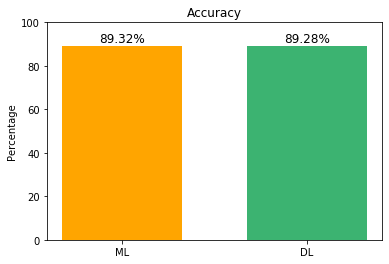

In [31]:
import matplotlib.pyplot as plt
x = ["ML", "DL"]
y = [89.32, 89.28]


plt.bar(x, y, width=0.65, color=['orange', 'mediumseagreen'])
plt.title("Accuracy")
plt.ylim(0, 100)
plt.ylabel('Percentage')

for a, b in zip(x, y):

    plt.text(a, b+0.05, '%1.2f%%' % b, ha='center', va='bottom', fontsize=12)

<mark> Training time of ML & DL <mark>

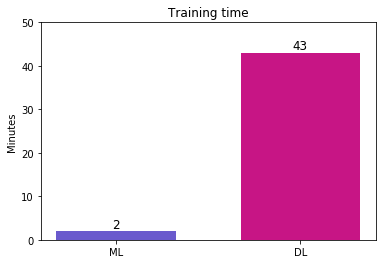

In [32]:
import matplotlib.pyplot as plt
x = ["ML", "DL"]
y = [2, 43]


plt.bar(x, y, width=0.65, color=['slateblue', 'mediumvioletred'])
plt.title("Training time")
plt.ylim(0, 50)
plt.ylabel('Minutes')

for a, b in zip(x, y):

    plt.text(a, b+0.05, '%0.f' % b, ha='center', va='bottom', fontsize=12)

## 5) Build a text generation model using topic ‘Sports’. Use it to generate 100 samples

### Language Model Design

In [1]:
import string
import re

<mark>Load Text<mark>

In [2]:
import pandas as pd
# 5000 samples of news
corpus_df = pd.read_csv('train9.csv', header=None)
corpus_df.columns = ['Category', 'Document']
corpus_df = corpus_df[corpus_df['Category'] == 'Sports']
corpus_df.head()
corpus = corpus_df['Document'].values
doc = corpus.tolist()
str = ''
doc = str.join(doc)
print(doc[:200])

AP - Washington Wizards point guard Steve Blake will miss the first month of the season after injuring his ankle in a pickup game.Baseball fans across Japan Saturday honored Ichiro Suzuki, the Seattle


<mark>Clean Text<mark>

In [3]:
# turn a doc into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

In [4]:
# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print()
print(f'Total Tokens: {len(tokens)}')
print(f'Unique Tokens: {len(set(tokens))}')

['ap', 'washington', 'wizards', 'point', 'guard', 'steve', 'blake', 'will', 'miss', 'the', 'first', 'month', 'of', 'the', 'season', 'after', 'injuring', 'his', 'ankle', 'in', 'a', 'pickup', 'gamebaseball', 'fans', 'across', 'japan', 'saturday', 'honored', 'ichiro', 'suzuki', 'the', 'seattle', 'mariners', 'japanese', 'player', 'who', 'broke', 'major', 'league', 'baseball', 'record', 'for', 'a', 'season', 'hitsit', 'was', 'two', 'years', 'ago', 'when', 'ernie', 'els', 'explained', 'how', 'it', 'was', 'possible', 'that', 'tiger', 'woods', 'could', 'be', 'overtaken', 'in', 'the', 'world', 'rankings', 'of', 'course', 'at', 'the', 'time', 'the', 'south', 'african', 'what', 'appeared', 'to', 'be', 'a', 'mismatch', 'took', 'a', 'turn', 'for', 'the', 'competitive', 'in', 'the', 'second', 'set', 'before', 'heninhardenne', 'regrouped', 'to', 'win', 'serena', 'williams', 'blamed', 'a', 'headache', 'for', 'her', 'poor', 'play', 'in', 'a', 'upset', 'loss', 'to', 'qualifier', 'alina', 'jidkova', 'in'

In [5]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i - length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 36263


<mark>Save Clean Text<mark>

In [6]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i - length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 36263


In [7]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [8]:
# save sequences to file
out_filename = 'sports_sequences.txt'
save_doc(sequences, out_filename)

### Train Language Model

In [28]:
from numpy import array
from pickle import dump
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

<mark>Load Sequences<mark>

In [10]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [11]:
# load
in_filename = 'sports_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

<mark>Encode Sequence<mark>

In [12]:
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [13]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7648


<mark>Sequence Inputs and Output<mark>

In [14]:
# separate into input and output
sequences = array(sequences)
X, y = sequences[:, :-1], sequences[:, -1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]
print(X.shape)
print(y.shape)

(36263, 50)
(36263, 7648)


<mark>Fit Model<mark>

In [15]:
# define the model
def define_model(vocab_size, seq_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length=seq_length))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    # compile network
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model_g.png', show_shapes=True)
    return model

In [16]:
# define model
model = define_model(vocab_size, seq_length)






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            382400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 7648)              772448    
Total params: 1,305,748
Trainable params: 1,305,748
Non-trainable params: 0
_________________________________________________________________


<mark>Save Model<mark>

In [17]:
answer = input(
    "Are you sure you want to train the model. It will take a long time. Type 'Yes' to continue. Anything else to skip.")
if answer == 'Yes':
    # define model
    model = define_model(vocab_size, seq_length)
    # fit model
    model.fit(X, y, batch_size=128, epochs=50)
    # save the model to file
    model.save('model2.h5')
    # save the tokenizer
    dump(tokenizer, open('tokenizer.pkl', 'wb'))

### Use Language Model

In [18]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

<mark>Load Data<mark>

In [19]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [20]:
# load cleaned text sequences
in_filename = 'sports_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [21]:
seq_length = len(lines[0].split()) - 1
print(seq_length)

50


<mark>Load Model<mark>

In [22]:
# load the model
model = load_model('model2.h5', compile=False)

In [23]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

<mark>Generate Text<mark>

In [24]:
# select a seed text
seed_text = lines[randint(0, len(lines))]
print(seed_text + '\n')

on saturdaythe way alex rodriguez jumped out of the batter box in the ninth inning last night he looked as happy as a little leaguer after his first big hitloudon nh sports network jeff gordon will assume the pole position for sunday sylvania at the new hampshire international speedway after a



In [25]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [26]:
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

steady celebration in the new york yankees and quite ohio on the first time in the final minutesvengoran weekap the new england patriots have it wasnt easysince the first time in the second inning in the second inning in the final class of highly seeds lleyton hewitt will be the


<mark>Using for loop to generate 100 sports news sample<mark>

In [27]:
a = []
for i in range(100):
    seed_text = lines[randint(0, len(lines))]
    generated = generate_seq(model, tokenizer, seq_length, seed_text, 88)
    a.append(generated)

<mark>Create dataframe for new 100 sample<mark>

In [29]:
data = {'Document': a}
df = pd.DataFrame(data, columns=['Document'])
df['Category'] = 'Sports'
df = df[['Category', 'Document']]
df.head()

,Category,Document
0,Sports,stages of the team for the team and a devil de...
1,Sports,likely to be fit for saturday on the team he c...
2,Sports,second pirates pittsburghs cup chief all the t...
3,Sports,replace onestroke internal autumn culminates f...
4,Sports,league nl fridaythe los angeles dodgers rallie...


<mark>Write to csv file<mark>

In [31]:
df.to_csv('sample.csv')

## 6) Use these 100 generated samples to test the performance of the ML & DL models

### Test ML (SVM) model

In [42]:
from nltk.corpus import stopwords
from gensim.models import word2vec
import string
import re
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.externals import joblib
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200
%matplotlib inline

<mark>Use the same w2v model get document level embeddings<mark>

In [62]:
corpus_df = pd.read_csv('train3.csv', header=None)
corpus_df.columns = ['Category', 'Document']
corpus = corpus_df['Document'].values

# Cleaning training data
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus.shape

(40000,)

In [63]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality
window_context = 30          # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

# Build model
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, iter=50)

In [64]:
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 50182 - Embedding Dim: 100


In [65]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

In [66]:
# Load 100 generated sample data as test data
corpus_df2 = pd.read_csv('sample.csv', header=None)
corpus_df2.columns = ['Category', 'Document']
corpus2 = corpus_df2['Document'].values

# Clean the testing data
norm_corpus2 = normalize_corpus(corpus2)
norm_corpus2.shape

# fit testing data into w2v model
tokenized_corpus2 = [wpt.tokenize(document) for document in norm_corpus2]

# get document level embeddings
w2v_feature_array2 = averaged_word_vectorizer(corpus=tokenized_corpus2, model=w2v_model,
                                              num_features=feature_size)
pd.DataFrame(w2v_feature_array2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-1.847784,0.132991,0.023631,0.935539,-0.195021,-1.288283,0.547306,0.213339,0.436048,-0.503643,...,0.713449,-0.543534,-1.175138,0.906836,-0.232104,-0.029717,-2.824145,0.612580,1.263698,1.803682
1,-2.189043,-0.279245,-1.009501,0.546516,-0.995631,-1.449291,0.345696,0.306930,1.149023,0.133607,...,0.175203,-0.078281,-1.640365,0.864689,-0.192158,-0.434408,-2.376381,1.204683,1.240302,1.744256
2,-0.812503,0.260584,-0.195387,0.466829,-0.432340,-0.843229,0.351714,0.151733,-0.256489,-0.136022,...,0.388044,0.284495,-1.153346,0.402060,0.252776,0.062953,-1.173212,0.450952,0.934383,1.054168
3,-2.600859,-0.213615,-0.743818,0.750528,-0.936309,-1.667650,-0.056886,-0.406998,1.262713,-0.137356,...,0.375475,-1.079031,-1.695178,1.172919,-0.574351,-0.719459,-3.701954,1.129937,1.734837,2.957388
4,-0.913640,-0.230554,-0.226524,0.902236,-0.205406,-1.221910,0.217581,0.368860,-0.117320,-0.575721,...,-0.434084,0.237051,-1.124399,0.473271,-0.251611,0.337884,-1.224569,0.435492,1.253399,0.887759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-2.595929,-0.350132,-1.248151,0.596087,-1.462927,-1.694892,0.198309,-0.295640,1.349536,-0.105495,...,0.366406,-0.953094,-2.022358,0.963399,-0.401150,-0.507663,-3.489565,1.342747,1.612514,2.570882
96,-1.510500,-0.033125,-0.824408,0.882340,-0.468357,-1.246829,0.627367,0.468577,0.462442,-0.109349,...,0.576700,-0.094986,-1.347305,0.543373,0.181485,-0.003572,-1.430578,1.036156,1.214435,1.406230
97,-1.986790,-0.000833,-0.481103,0.887314,-0.520862,-1.657750,-0.129073,-0.037732,1.119915,-0.362989,...,0.263814,-0.790301,-1.226264,1.208289,-0.335279,-0.569296,-3.257815,0.392643,1.594304,2.874302
98,-2.463994,-0.294856,-1.388945,0.946770,-0.891211,-1.756670,-0.269740,-0.104142,1.198939,-0.321465,...,-0.477956,-0.679434,-1.503008,1.170296,-0.129007,-0.313280,-2.773789,0.969906,1.923504,1.824114


<mark>Prepare X test and Y test <mark>

In [67]:
# Set X_train, y_train, x_test, y_test
df = pd.read_csv('train3.csv', header=None)
df.columns = ['Category', 'Text']
df.head()
# create new column and new category_id for Category name
df['category_id'] = df['Category'].factorize()[0]

# Create a new pandas dataframe "category_id_df", use it to iterate over the categories
category_id_df = df[['Category', 'category_id']
                    ].drop_duplicates().sort_values('category_id')
category_id_df
# Create a dictionary that can easily convert category names into category_ids
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category

df2 = pd.read_csv('sample.csv', header=None)
df2.columns = ['Category', 'Text']
df2.head()
df2['category_id'] = df2['Category'].factorize()[0]


features2 = pd.DataFrame(w2v_feature_array2).values
labels2 = df2.category_id


X_test = features2
y_test = labels2
print(X_test.shape)
print(y_test.shape)

(100, 100)
(100,)


In [68]:
y_test = []
for i in range(100):
    a = 1
    y_test.append(a)
y_test = np.array(y_test)

<mark>Load SVM model <mark>

In [69]:
model = joblib.load('svmmodel.pkl')

<mark>Accuracy <mark>

In [70]:
# Make Predictions
y_pred = model.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.99


### Test DL (LSTM) model

In [71]:
from nltk.corpus import stopwords
from gensim.models import word2vec
import string
import re
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.models import load_model
pd.options.display.max_colwidth = 200
%matplotlib inline

<mark>Use the same w2v model to tokenize the 100 generated samples<mark>

In [72]:
# Load training data
corpus_df = pd.read_csv('train3.csv', header=None)
corpus_df.columns = ['Category', 'Document']
corpus = corpus_df['Document'].values

# Cleaning training data
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus.shape

(40000,)

In [73]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality
window_context = 30          # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

# Build model
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, iter=50)

In [74]:
# Retrieve the weights from the model.
# This is used for initializing the weightsin Keras Embedding layer
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 50182 - Embedding Dim: 100


In [75]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    except KeyError:
        return 0


def token2word(token):
    return w2v_model.wv.index2word[token]

<mark>Prepare test data<mark>

In [76]:
corpus_df2 = pd.read_csv('sample.csv', header=None)
corpus_df2.columns = ['Category', 'Document']

In [77]:
# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 88


class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(
            dataset.Category, return_counts=True)

        self.seq_length = seq_length

    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 1], self.dataset.iloc[:, 0]):

            # Make all characters lower-case
            news = news.lower()

            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[
                             :self.seq_length] if w != ''])

            yield (words, cat)


sequences = SequenceIterator(corpus_df2, MAX_SEQUENCE_LENGTH)

# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(
    sequences.categories, range(len(sequences.categories)))}

set_x2 = []
set_y2 = []
for w, c in sequences:
    set_x2.append(w)
    set_y2.append(cat_dict[c])

# Padding sequences with 0.
set_x2 = pad_sequences(
    set_x2, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y2 = np.array(set_y2)

print(set_x2.shape)
print(set_y2.shape)

(100, 88)
(100,)


In [83]:
test_x = set_x2
test_y = []
for i in range(100):
    a = 2
    test_y.append(a)
test_y = np.array(test_y)
print("Test Shapes - X: {} - Y: {}".format(test_x.shape, test_y.shape))

Test Shapes - X: (100, 88) - Y: (100,)


<mark>Load LSTM model<mark>

In [87]:
model = load_model('model.h5')

<mark>Accuracy<mark>

In [88]:
score = model.evaluate(test_x,  test_y,
                       batch_size=32, verbose=1)

print("Test Accuracy: %.2f%%" % (score[1]*100))

100/100 [==============================] - 1s 10ms/step
Test Accuracy: 100.00%


### Summary: Performance results

<mark>Performance of ML & DL <mark>

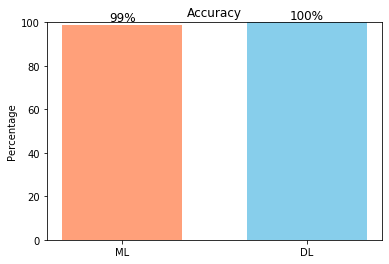

In [94]:
import matplotlib.pyplot as plt
x = ["ML", "DL"]
y = [99, 100]

plt.bar(x, y, width=0.65, color=['lightsalmon', 'skyblue'])
plt.title("Accuracy")
plt.ylim(0, 100)
plt.ylabel('Percentage')

for a, b in zip(x, y):
    plt.text(a, b+0.05, '%1.0f%%' % b, ha='center', va='bottom', fontsize=12)